In [23]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json

## Loading results

In [24]:
rca = pd.read_csv('../../data/final/rca.csv')
meta = pd.read_csv('../../data/raw/psychNorms_metadata.csv', index_col='norm')

# Adding norm category
rca['norm_category'] = (
    rca['norm'].apply(lambda norm: meta.loc[norm]['category'])
    .replace({'_': ' ', '/': ' / '}, regex=True)
)
rca

,embed,embed_type,norm,train_n,p,r2_mean,r2_sd,check,norm_category
0,CBOW_GoogleNews,text,Freq_HAL,51174,300,0.422344,0.006255,pass,frequency
1,CBOW_GoogleNews,text,Freq_KF,26605,300,0.463358,0.009852,pass,frequency
2,CBOW_GoogleNews,text,Freq_SUBTLEXUS,43939,300,0.488748,0.006706,pass,frequency
3,CBOW_GoogleNews,text,Freq_SUBTLEXUK,47398,300,0.479608,0.008173,pass,frequency
4,CBOW_GoogleNews,text,Freq_Blog,53251,300,0.463084,0.006165,pass,frequency
...,...,...,...,...,...,...,...,...,...
7295,THINGS,behavior,familiarity_vanarsdall,376,49,0.060692,0.083942,pass,familiarity
7296,THINGS,behavior,imageability_vanarsdall,376,49,0.053593,0.095680,pass,imageability
7297,THINGS,behavior,familiarity_fear,173,49,0.139160,0.160894,pass,familiarity
7298,THINGS,behavior,aoa_fear,173,49,-0.021206,0.121789,pass,age of acquisition


In [25]:
with open('../../data/raw/embed_to_dtype.json', 'r') as f:
    embed_to_type = json.load(f)
    
rca['embed_type'] = rca['embed'].map(embed_to_type)
rca

,embed,embed_type,norm,train_n,p,r2_mean,r2_sd,check,norm_category
0,CBOW_GoogleNews,text,Freq_HAL,51174,300,0.422344,0.006255,pass,frequency
1,CBOW_GoogleNews,text,Freq_KF,26605,300,0.463358,0.009852,pass,frequency
2,CBOW_GoogleNews,text,Freq_SUBTLEXUS,43939,300,0.488748,0.006706,pass,frequency
3,CBOW_GoogleNews,text,Freq_SUBTLEXUK,47398,300,0.479608,0.008173,pass,frequency
4,CBOW_GoogleNews,text,Freq_Blog,53251,300,0.463084,0.006165,pass,frequency
...,...,...,...,...,...,...,...,...,...
7295,THINGS,behavior,familiarity_vanarsdall,376,49,0.060692,0.083942,pass,familiarity
7296,THINGS,behavior,imageability_vanarsdall,376,49,0.053593,0.095680,pass,imageability
7297,THINGS,behavior,familiarity_fear,173,49,0.139160,0.160894,pass,familiarity
7298,THINGS,behavior,aoa_fear,173,49,-0.021206,0.121789,pass,age of acquisition


In [26]:
# Taking the embedding with the highest mean r2 from each embed_type
top_embeds = (
    rca[['embed', 'embed_type', 'r2_mean']]
    .groupby(['embed', 'embed_type'], as_index=False)
    .mean('r2_mean').set_index('embed')
    .groupby('embed_type').idxmax()['r2_mean']
)    

top_embeds

embed_type
behavior      PPMI_SVD_SWOW
brain              EEG_text
text        CBOW_GoogleNews
Name: r2_mean, dtype: object

In [27]:
# Ordering norms by top behavior model mean r2
top_behav= top_embeds['behavior']
norm_order = (
    rca[rca['embed'] == top_behav][['norm_category', 'r2_mean']]
    .groupby('norm_category').mean().sort_values(by='r2_mean')
    .index
)
rca['norm_category'] = pd.Categorical(rca['norm_category'], norm_order)
rca = rca.sort_values(by='norm_category').reset_index(drop=True)
rca

,embed,embed_type,norm,train_n,p,r2_mean,r2_sd,check,norm_category
0,PPMI_SVD_SouthFlorida,behavior,imageability_rt_cortese,1385,300,0.118634,0.014151,pass,semantic decision
1,EEG_text,brain,rt_chen,102,104,-0.069224,0.034431,pass,semantic decision
2,GloVe_CommonCrawl,text,rt_khanna,1046,300,-0.037964,0.044596,pass,semantic decision
3,fastText_CommonCrawl,text,aoa_rt_cortese,2397,300,-0.049627,0.052589,pass,semantic decision
4,eye_tracking,brain,imageability_rt_cortese,958,6,-0.010582,0.015625,pass,semantic decision
...,...,...,...,...,...,...,...,...,...
7295,fastText_CommonCrawl,text,valence_imbault,1827,300,0.553491,0.044491,pass,valence
7296,GloVe_CommonCrawl,text,valence_hollis,831,300,0.747624,0.074644,pass,valence
7297,GloVe_Twitter,text,Pleasant_Binder,425,200,0.314151,0.054039,pass,valence
7298,GloVe_CommonCrawl,text,pleasantness_brown,511,300,0.592717,0.099440,pass,valence


In [28]:
# rca mean
rca_mean = (
    rca[['norm_category', 'embed', 'r2_mean']]
    .groupby(['norm_category', 'embed'], as_index=False).mean()
)
rca_mean

,norm_category,embed,r2_mean
0,semantic decision,CBOW_GoogleNews,0.136281
1,semantic decision,EEG_speech,-0.151619
2,semantic decision,EEG_text,-0.317320
3,semantic decision,GloVe_CommonCrawl,-0.328225
4,semantic decision,GloVe_Twitter,-0.272569
...,...,...,...
670,valence,fastText_Wiki_News,0.585010
671,valence,microarray,-33.256450
672,valence,morphoNLM,0.287128
673,valence,norms_sensorimotor,0.081135


## Scatter plot

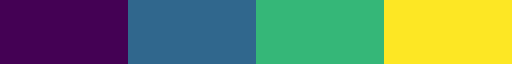

In [29]:
plt.get_cmap('viridis', 4)

In [30]:
# Colors 
cmap = plt.get_cmap('viridis', 4)
embed_type_to_color = {
    'brain': cmap(1),
    'behavior': cmap(0),
    'text': cmap(2)
}
{key: mcolors.to_hex(value) for key, value in embed_type_to_color.items()}

{'brain': '#31688e', 'behavior': '#440154', 'text': '#35b779'}

**Top embeddings**

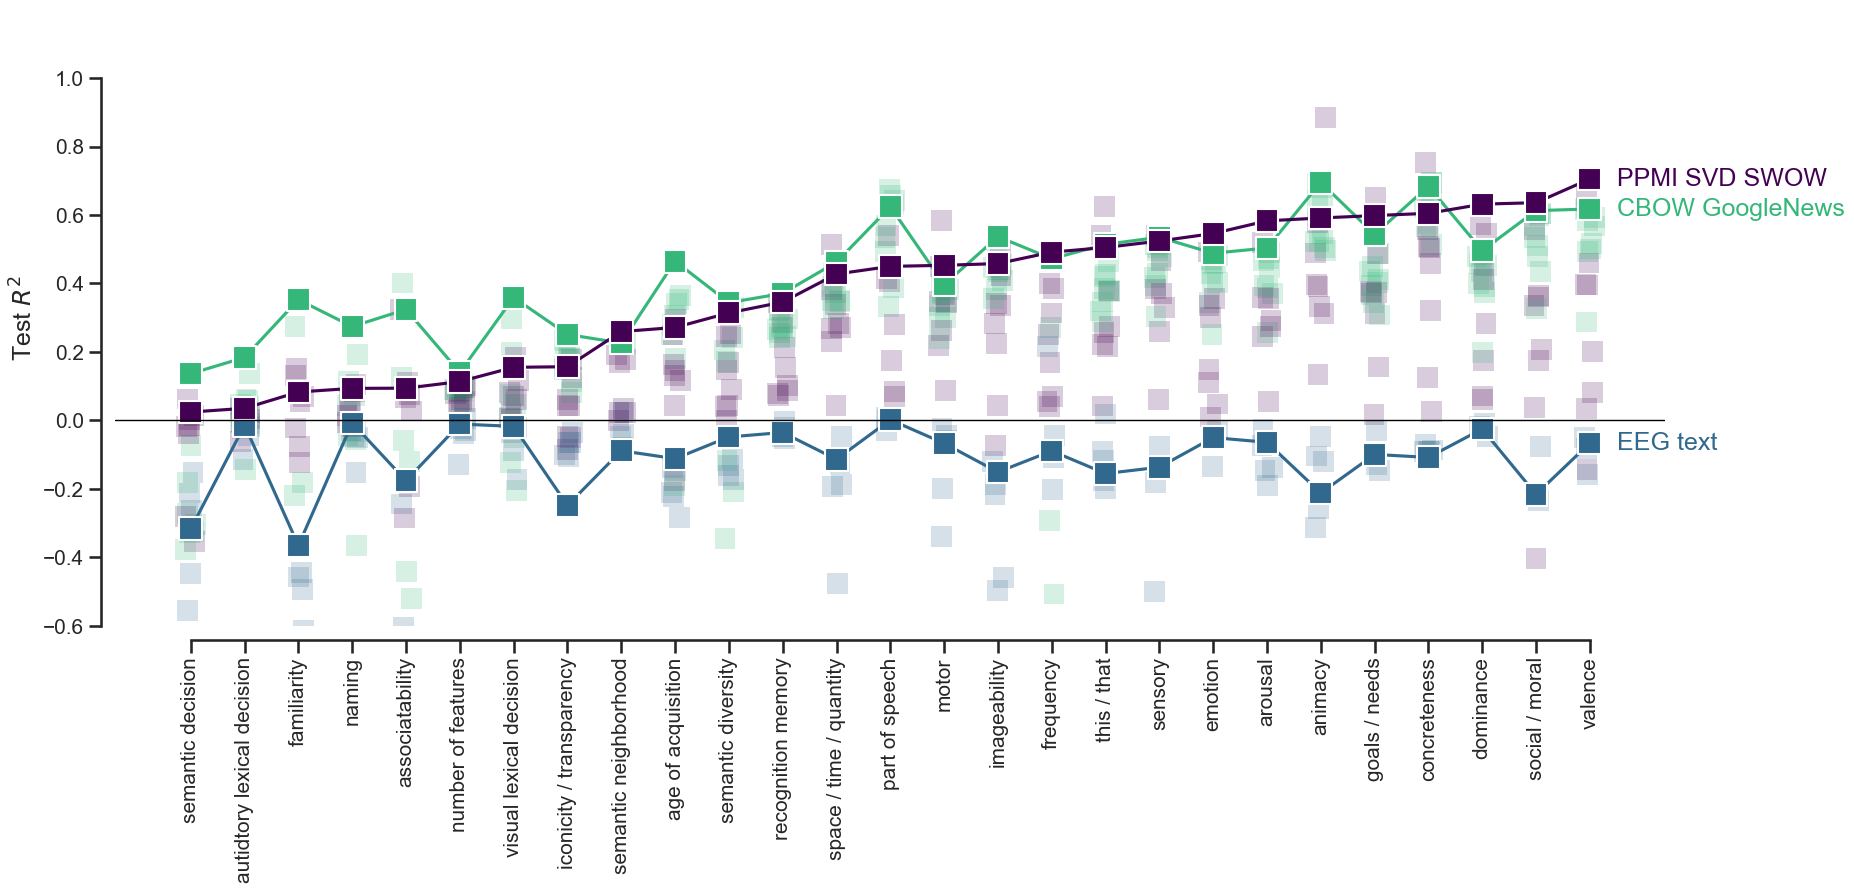

In [31]:
sns.set(context='talk', style='white')
fig, ax = plt.subplots(figsize=(20, 8))

embed_to_color = {embed : embed_type_to_color[embed_to_type[embed]] for embed in embed_to_type.keys()}

sns.stripplot(
    rca_mean.query('embed not in @top_embeds'),
    x='norm_category', y='r2_mean', hue='embed', 
    s=15, marker='s', palette=embed_to_color, alpha=.2, 
    zorder=0, ax=ax
)

sns.lineplot(
    rca_mean.query('embed in @top_embeds'),
    x='norm_category', y='r2_mean', hue='embed',
    palette=embed_to_color, zorder=1, ax=ax
)

# Square markers
sns.scatterplot(
    rca_mean.query('embed in @top_embeds'), marker='s',
    x='norm_category', y='r2_mean', hue='embed',
    s=270, palette=embed_to_color, edgecolor='white', linewidth=1.5,
    zorder=2, ax=ax
)

ax.legend_.remove()

# Labelling top embeddings on the right side in line with their right hand points
occ_ys = []
for embed in top_embeds:
    x = 26.5
    y = rca_mean.query('embed == @embed')['r2_mean'].iloc[-1]
    if occ_ys:
        while min([abs(y - occ_y) for occ_y in occ_ys]) < 0.08:
            np.random.seed(42)
            y += np.random.uniform(-0.05, 0.05)
    occ_ys.append(y)
    ax.text(x, y, embed.replace('_', ' '), ha='left', va='center', color=embed_to_color[embed], fontsize=18)


ax.set(
    ylim=(-.6, 1.2), xlabel='', ylabel='Test $R^2$',
    yticks=np.arange(-.6, 1.2, .2)
)
ax.axhline(0, color='black', lw=1)
ax.tick_params(axis='x', rotation=90, which='both', bottom=True, top=False, labelbottom=True, labelsize=15)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelsize=15)

sns.despine(offset=10, trim=True)
plt.savefig('../../figures/rca.png', dpi=300, bbox_inches='tight')

## Heatmap

In [32]:
norm_order

Index(['semantic decision', 'autidtory lexical decision', 'familiarity',
       'naming', 'associatability', 'number of features',
       'visual lexical decision', 'iconicity / transparency',
       'semantic neighborhood', 'age of acquisition', 'semantic diversity',
       'recognition memory', 'space / time / quantity', 'part of speech',
       'motor', 'imageability', 'frequency', 'this / that', 'sensory',
       'emotion', 'arousal', 'animacy', 'goals / needs', 'concreteness',
       'dominance', 'social / moral', 'valence'],
      dtype='object', name='norm_category')

In [33]:
# Pivots rca_mean to a matrix for each embed type
rca_mean['embed_type'] = rca_mean['embed'].map(embed_to_type)

rca_mean_pivs = {}
embed_types = ['text', 'brain', 'behavior']
for embed_type in embed_types:
    rca_mean_piv = rca_mean.query('embed_type == @embed_type').pivot(index='embed', columns='norm_category', values='r2_mean')
    
    # Sorts index by grand mean of embeds
    embed_order = rca_mean_piv.mean(axis=1).sort_values(ascending=False).index
    rca_mean_pivs[embed_type] = rca_mean_piv[norm_order].loc[embed_order]

rca_mean.query('embed_type == "text"').pivot(index='embed', columns='norm_category', values='r2_mean')

norm_category,semantic decision,autidtory lexical decision,familiarity,naming,associatability,number of features,visual lexical decision,iconicity / transparency,semantic neighborhood,age of acquisition,...,this / that,sensory,emotion,arousal,animacy,goals / needs,concreteness,dominance,social / moral,valence
embed,,,,,,,,,,,,,,,,,,,,,
CBOW_GoogleNews,0.136281,0.183671,0.352517,0.274019,0.323883,0.140077,0.358843,0.250801,2.257941e-01,0.465041,...,0.514202,0.534737,0.488208,0.503372,0.695176,0.543065,0.683907,0.496069,0.612661,0.617422
GloVe_CommonCrawl,-0.328225,0.046126,-3.358612,-0.045369,-0.519686,0.088467,-0.204461,0.180299,-9.143041e+02,0.352305,...,0.375962,0.514041,0.469721,0.489208,0.641335,0.436374,0.639256,0.484133,0.604350,0.616321
GloVe_Twitter,-0.272569,-0.009159,-1.080700,-0.031657,-0.119654,0.094623,0.197932,0.156042,-1.073794e+01,0.249125,...,0.378955,0.393091,0.344972,0.386430,0.544412,0.403356,0.564996,0.373793,0.510153,0.492475
GloVe_Wikipedia,-0.073989,-0.008145,-0.182847,-0.057718,0.124076,0.085852,-0.051298,0.112065,-2.202715e+01,0.342486,...,0.425130,0.418029,0.403950,0.370142,0.496206,0.394185,0.574430,0.391740,0.433986,0.516983
LexVec_CommonCrawl,-0.304391,0.057161,-1.242865,0.042996,-0.689158,0.103792,0.045311,0.189950,-9.789581e+04,0.180108,...,0.463203,0.496177,0.461878,0.472629,0.679500,0.487606,0.639704,0.433991,0.602662,0.592406
fastTextSub_OpenSub,-0.972238,-0.143930,-2.212297,-0.366221,-2.330433,0.049673,-1.167583,0.233688,-1.323262e+01,-0.190449,...,0.319192,0.503446,0.428552,0.466578,0.639511,0.411441,0.694477,0.459224,0.569551,0.567966
fastText_CommonCrawl,-0.326078,0.009467,-5.395508,-0.011896,-0.442257,0.091789,-0.123804,0.211893,-1.566822e+01,0.306074,...,0.420602,0.513229,0.481173,0.504871,0.693152,0.343860,0.694394,0.477479,0.598958,0.620987
fastText_Wiki_News,-0.377816,0.040612,-0.869233,0.112726,-0.058131,0.098942,0.008572,0.181198,-4.239428e+00,0.280568,...,0.345880,0.478719,0.456621,0.447205,0.523654,0.366319,0.665168,0.451099,0.535274,0.585010
morphoNLM,0.141227,0.136295,0.274788,0.193137,0.401355,0.089346,0.295846,0.081948,2.248690e-01,0.364056,...,0.287842,0.302427,0.250501,0.256193,0.504349,0.307913,0.513777,0.197220,0.325596,0.287128


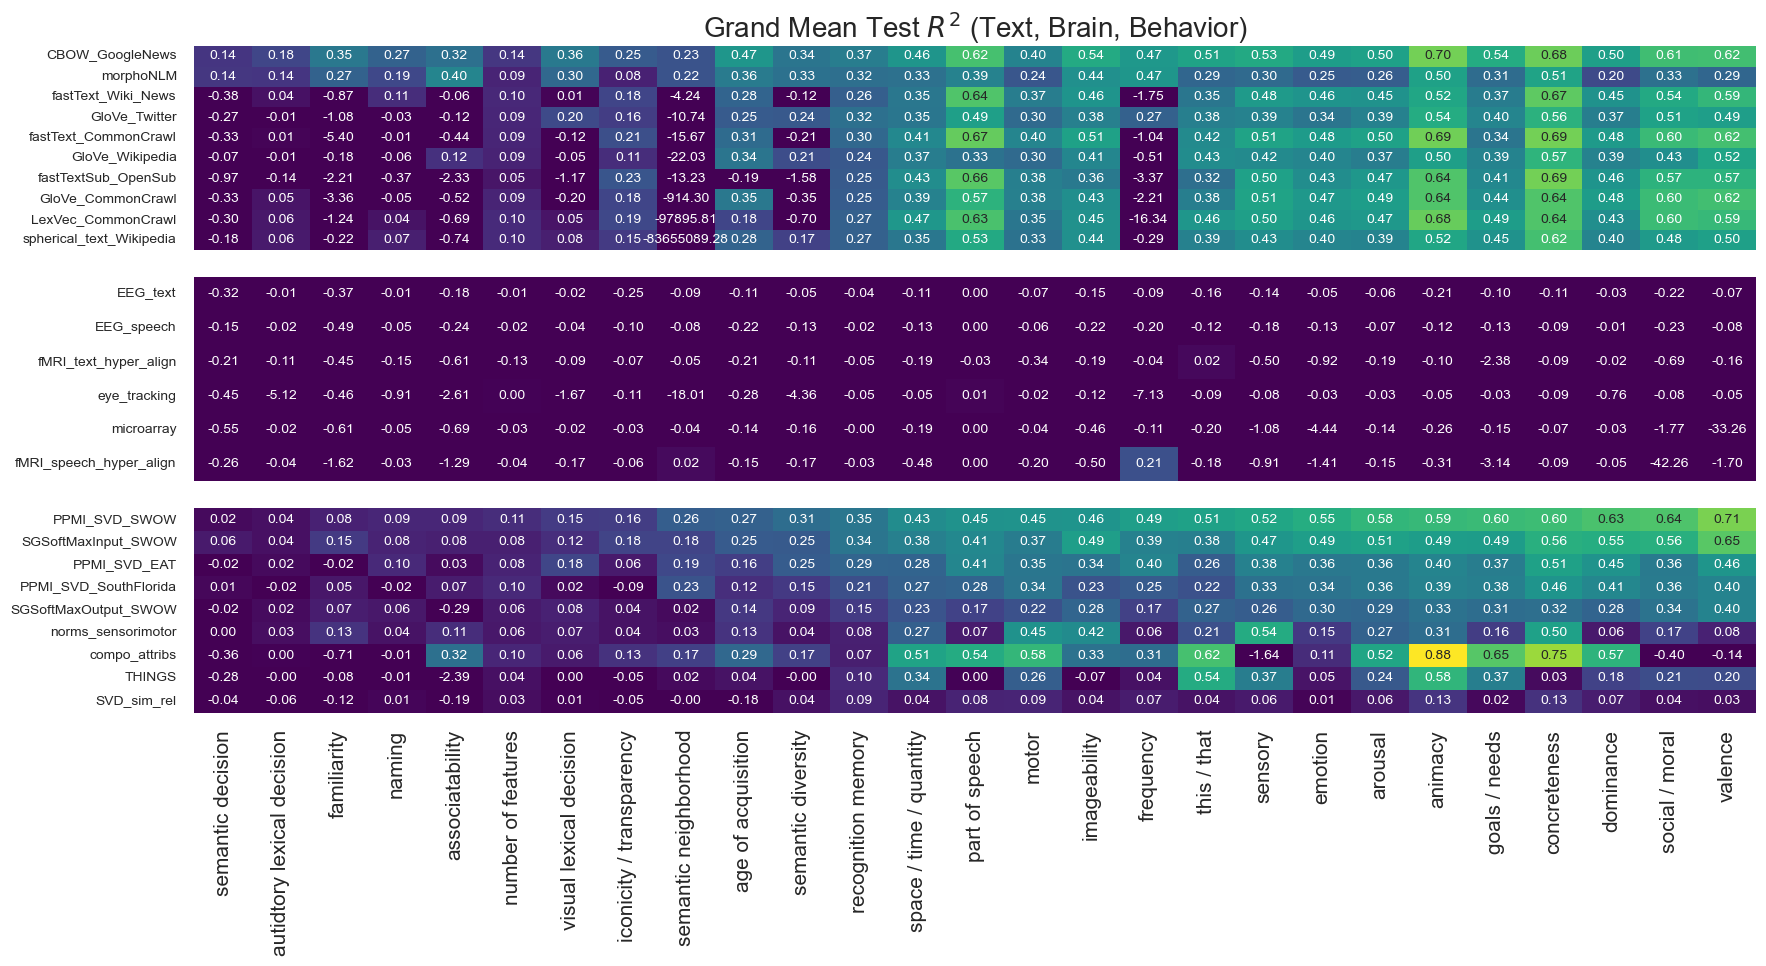

In [34]:
fig, axs = plt.subplots(3, 1, figsize=(18, 10))

for i, embed_type in enumerate(embed_types):
    sns.heatmap(
        rca_mean_pivs[embed_type], cmap='viridis', ax=axs[i], vmin=0, vmax=rca_mean['r2_mean'].max(),
        annot=True, fmt='.2f', annot_kws={'fontsize': 10}, cbar=False
    )
    axs[i].set(xlabel='', ylabel='', xticklabels=[])
    
    # Ensure y-axis labels match the number of ticks
    axs[i].set_yticks(pd.Series(range(len(rca_mean_pivs[embed_type].index))) + .5)
    axs[i].set_yticklabels(rca_mean_pivs[embed_type].index, fontsize=10)
    
# Adding xticklabels to last plot
axs[-1].set_xticklabels(norm_order, rotation=90, fontsize=15)

# Sets figure title
axs[0].set_title('Grand Mean Test $R^2$ (Text, Brain, Behavior)', fontsize=20)
    
fig.tight_layout()
plt.savefig('../../figures/rca_heatmap.png', dpi=300, bbox_inches='tight')